In [1]:
import pandas as pd
import plotnine as p9
import datetime as dt

In [2]:
df = pd.read_parquet('data/fct_teachers_entries.parquet')
df.head()

,unique_id,user_type,data_inicio,data_fim
0,648c29c1-5c68-4308-bc40-f85a4ab760f8,seo,2022-12-12 15:35:03.601000+00:00,2022-12-12 15:35:36.305000+00:00
1,463135f9-2345-4b25-845f-bc52f6e41362,seo,2023-04-11 08:55:55.225000+00:00,2023-04-11 08:56:56.637000+00:00
2,0bb96cab-5bd6-4e80-beff-9bb58590b0cb,seo,2023-03-30 12:27:39.857000+00:00,2023-03-30 12:27:40.077000+00:00
3,6d38f15b-a76d-4b92-bddb-1d6e4ec4deec,seo,2023-06-06 22:20:14.298000+00:00,2023-06-06 22:20:14.629000+00:00
4,4c3edd9b-2f40-491f-9e88-5e8bf90accbb,seo,2023-05-29 19:26:15.913000+00:00,2023-05-29 19:26:16.139000+00:00


In [3]:
df['duracao_minutos'] = pd.to_datetime(df['data_fim']) - pd.to_datetime(df['data_inicio'])
df['duracao_minutos'] = df['duracao_minutos'].dt.total_seconds() / 60
df.head()

,unique_id,user_type,data_inicio,data_fim,duracao_minutos
0,648c29c1-5c68-4308-bc40-f85a4ab760f8,seo,2022-12-12 15:35:03.601000+00:00,2022-12-12 15:35:36.305000+00:00,0.545067
1,463135f9-2345-4b25-845f-bc52f6e41362,seo,2023-04-11 08:55:55.225000+00:00,2023-04-11 08:56:56.637000+00:00,1.023533
2,0bb96cab-5bd6-4e80-beff-9bb58590b0cb,seo,2023-03-30 12:27:39.857000+00:00,2023-03-30 12:27:40.077000+00:00,0.003667
3,6d38f15b-a76d-4b92-bddb-1d6e4ec4deec,seo,2023-06-06 22:20:14.298000+00:00,2023-06-06 22:20:14.629000+00:00,0.005517
4,4c3edd9b-2f40-491f-9e88-5e8bf90accbb,seo,2023-05-29 19:26:15.913000+00:00,2023-05-29 19:26:16.139000+00:00,0.003767


In [4]:
df['data_inicio'] = pd.to_datetime(df['data_inicio']).dt.tz_localize(None)
df['data_fim'] = pd.to_datetime(df['data_fim']).dt.tz_localize(None)
ref_date = df['data_inicio'].max() + dt.timedelta(days=1)

In [5]:
rfm = df.groupby('unique_id').agg({
    'data_inicio': lambda x: (ref_date - x.max()).days,
    'unique_id': 'count',
    'duracao_minutos': 'sum'
}).rename(columns={
    'data_inicio': 'Recency',
    'unique_id': 'Frequency',
    'duracao_minutos': 'Duration'
})


In [6]:
rfm.describe()

,Recency,Frequency,Duration
count,1.317999e+06,1.317999e+06,1.317999e+06
mean,5.758943e+02,1.855882e+00,4.341598e+00
std,3.157921e+02,1.507777e+01,1.722517e+02
min,1.000000e+00,1.000000e+00,0.000000e+00
25%,3.320000e+02,1.000000e+00,3.833333e-03
50%,5.240000e+02,1.000000e+00,3.561667e-02
75%,8.290000e+02,1.000000e+00,5.605917e-01
max,1.275000e+03,1.121500e+04,1.355038e+05


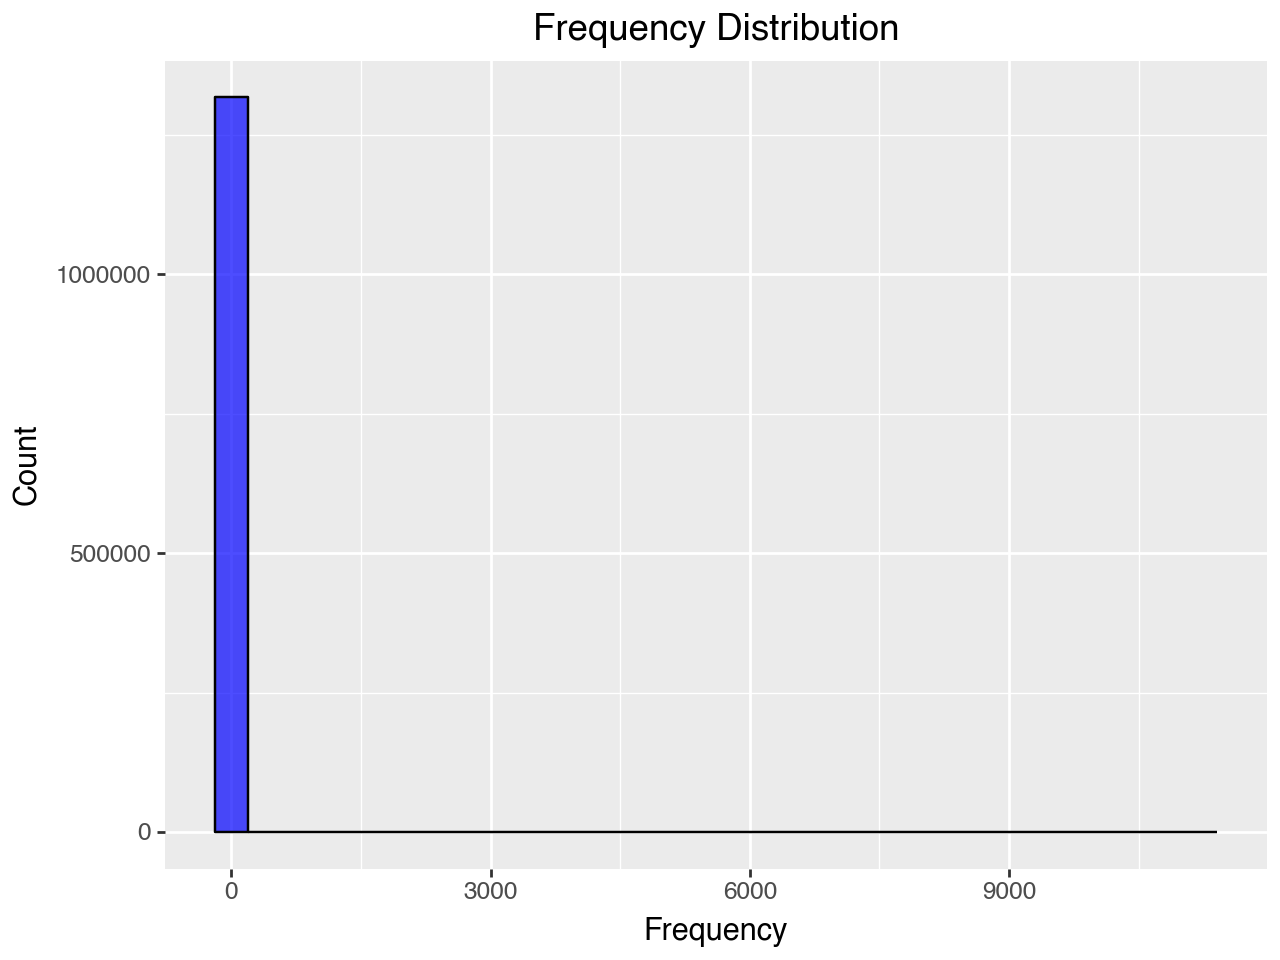

In [7]:
(
    p9.ggplot(rfm, p9.aes(x='Frequency')) + 
    p9.geom_histogram(bins=30, fill='blue', color='black', alpha=0.7) +
    p9.ggtitle('Frequency Distribution') +
    p9.xlab('Frequency') +
    p9.ylab('Count')
)

In [8]:

# Score por quintis
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['Duration'], 5, labels=[1,2,3,4,5])

# Criar código RFM
rfm['RFM_Segment'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm['RFM_Score'] = rfm[['R_score','F_score','M_score']].astype(int).sum(axis=1)

rfm.head()


,Recency,Frequency,Duration,R_score,F_score,M_score,RFM_Segment,RFM_Score
unique_id,,,,,,,,
000005b8-e073-4b3d-858a-cc2a51f6ae76,720,1,0.254767,2,1,3,213,6
00000ac4-2412-4cba-a7fd-000271cd2459,1092,1,0.003600,1,1,2,112,4
00001d14-1398-4e03-b1b7-561cb2d2423a,324,2,0.019233,4,4,3,443,11
00003562-eb2f-481b-a082-f30dc8cb3d4a,659,2,3.380883,3,4,5,345,12
00003a13-91d1-46bf-934d-72f17f4c5a12,339,1,0.326367,4,1,3,413,8


/var/folders/kd/9dcr76gj6r54_pq8wpxx3k300000gn/T/ipykernel_59477/13962524.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


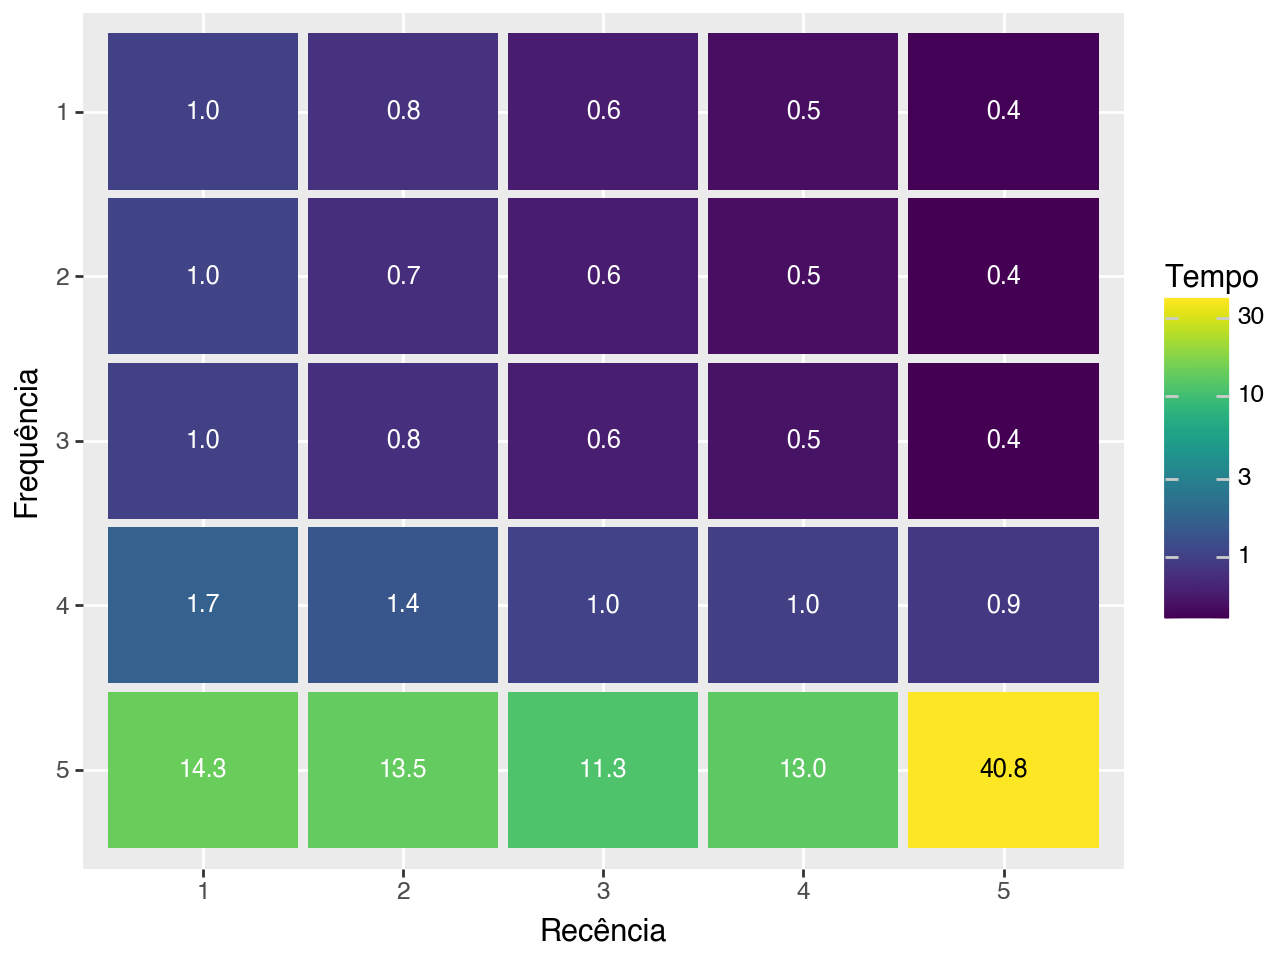

In [9]:
heatmap_Duration = rfm.groupby(['R_score', 'F_score']).agg({'Duration': 'mean'}).reset_index()
heatmap_Duration['p_cut'] = pd.cut(
    heatmap_Duration['Duration'], (0, 20, 50), labels=("low", "high")
)
heatmap_Duration['Duration_fmt'] = heatmap_Duration['Duration'].round(1)

(
    p9.ggplot(heatmap_Duration, p9.aes(x='R_score', y='F_score', fill='Duration')) +
    p9.geom_tile(p9.aes(width=0.95, height=0.95)) +
    p9.geom_text(p9.aes(label='Duration_fmt', color='p_cut'), size=9, show_legend=False) +
    p9.scale_color_manual(['white', 'black']) +
    p9.scale_fill_cmap(cmap_name='viridis', trans="log10") +
    p9.scale_y_discrete(limits=heatmap_Duration['F_score'].unique()[::-1]) +
    p9.scale_x_discrete(limits=heatmap_Duration['R_score'].unique()[::-1]) +
    p9.labs(
        x="Recência",
        y="Frequência",
        fill="Tempo"
    )
)

/Users/guilhermefidalgo/Library/CloudStorage/OneDrive-SharedLibraries-Insper-InstitutodeEnsinoePesquisa/PRÁTICA AVANÇADA EM DATA SCIENCE E VISUALIZATION - Grupo 1/Shiny AprendiZAP/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


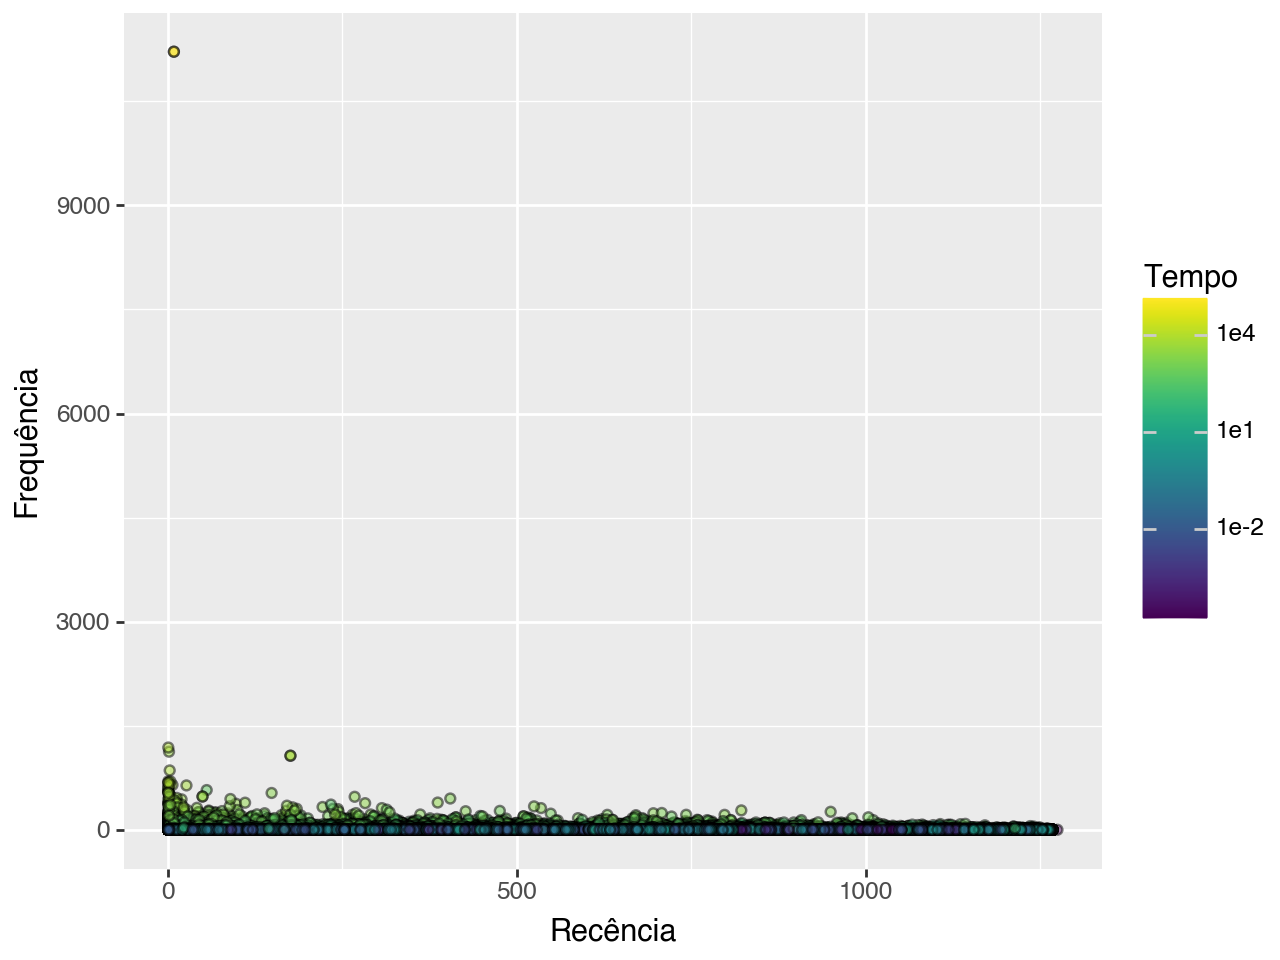

In [10]:
(
    p9.ggplot(rfm, p9.aes(x='Recency', y='Frequency', fill='Duration')) +
    p9.geom_point(alpha=0.5) +
    p9.scale_fill_cmap(cmap_name='viridis', trans="log10") +
    p9.labs(
        x="Recência",
        y="Frequência",
        fill="Tempo"
    )
)

/Users/guilhermefidalgo/Library/CloudStorage/OneDrive-SharedLibraries-Insper-InstitutodeEnsinoePesquisa/PRÁTICA AVANÇADA EM DATA SCIENCE E VISUALIZATION - Grupo 1/Shiny AprendiZAP/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


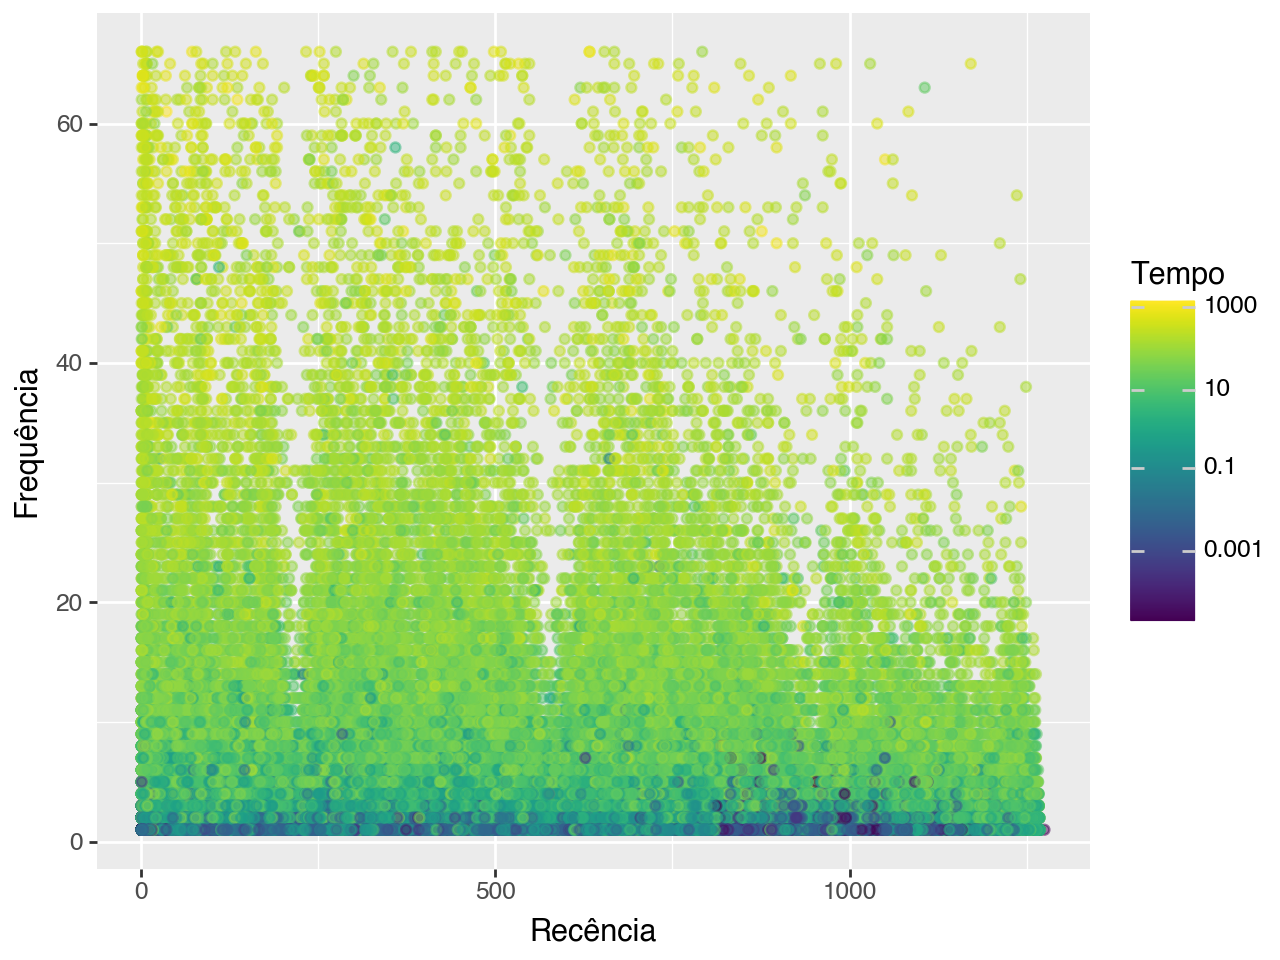

In [11]:
# Removendo outliers em Frequency
rfm_clean = rfm[rfm['Frequency'] < rfm['Frequency'].quantile(0.999)]

(
    p9.ggplot(rfm_clean, p9.aes(x='Recency', y='Frequency', color='Duration')) +
    p9.geom_point(alpha=0.5) +
    p9.scale_color_cmap(cmap_name='viridis', trans="log10") +
    p9.labs(
        x="Recência",
        y="Frequência",
        color="Tempo"
    )
)

In [12]:
rfm.head()

,Recency,Frequency,Duration,R_score,F_score,M_score,RFM_Segment,RFM_Score
unique_id,,,,,,,,
000005b8-e073-4b3d-858a-cc2a51f6ae76,720,1,0.254767,2,1,3,213,6
00000ac4-2412-4cba-a7fd-000271cd2459,1092,1,0.003600,1,1,2,112,4
00001d14-1398-4e03-b1b7-561cb2d2423a,324,2,0.019233,4,4,3,443,11
00003562-eb2f-481b-a082-f30dc8cb3d4a,659,2,3.380883,3,4,5,345,12
00003a13-91d1-46bf-934d-72f17f4c5a12,339,1,0.326367,4,1,3,413,8


/var/folders/kd/9dcr76gj6r54_pq8wpxx3k300000gn/T/ipykernel_59477/1583959661.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


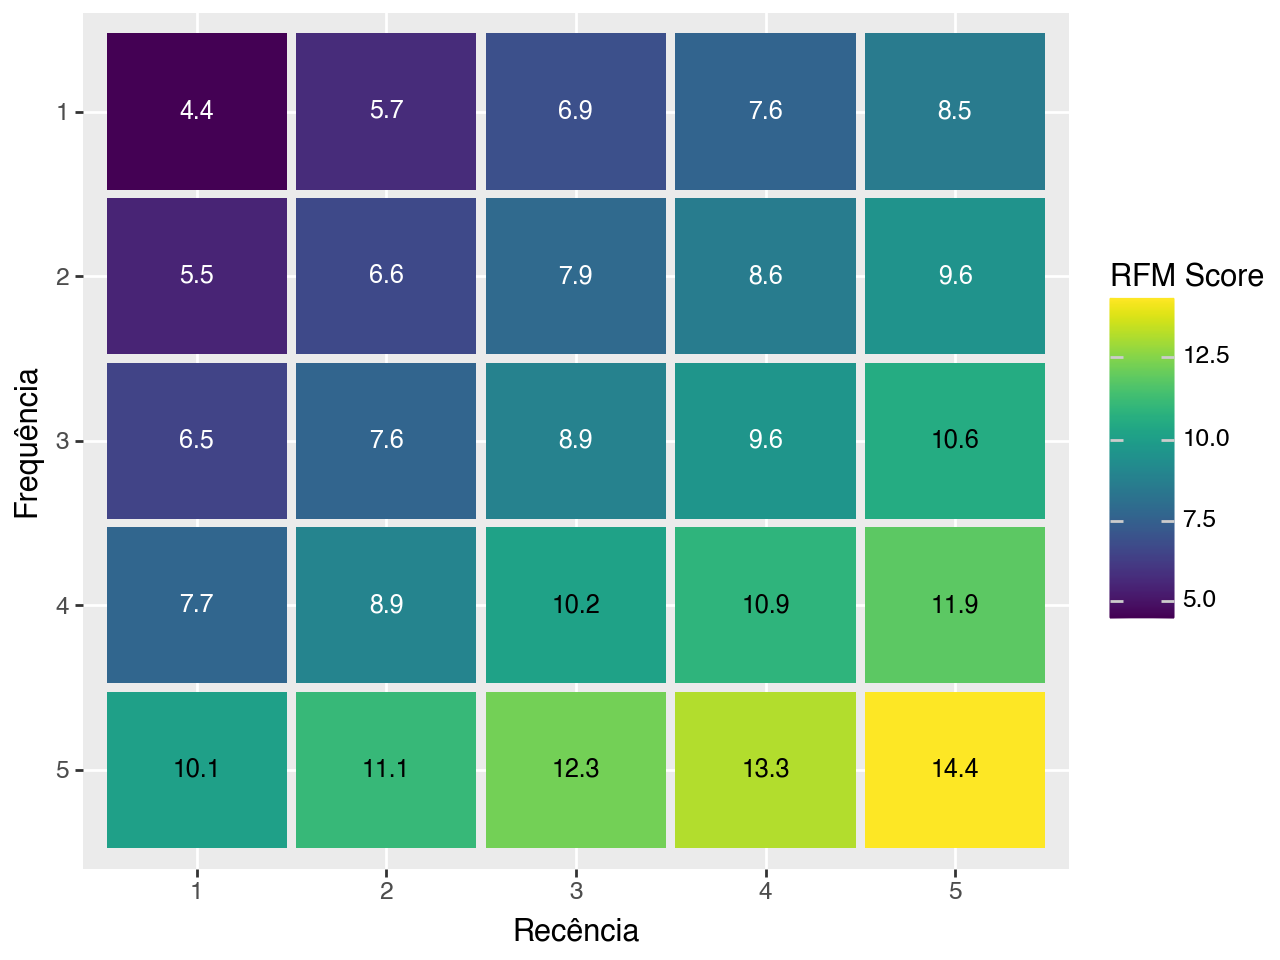

In [13]:
heatmap_score = rfm.groupby(['R_score', 'F_score']).agg({'RFM_Score': 'mean'}).reset_index()
heatmap_score['p_cut'] = pd.cut(
    heatmap_score['RFM_Score'], (0, 10, 50), labels=("low", "high")
)
heatmap_score['RFM_Score_fmt'] = heatmap_score['RFM_Score'].round(1)

(
    p9.ggplot(heatmap_score, p9.aes(x='R_score', y='F_score', fill='RFM_Score')) +
    p9.geom_tile(p9.aes(width=0.95, height=0.95)) +
    p9.geom_text(p9.aes(label='RFM_Score_fmt', color='p_cut'), size=9, show_legend=False) +
    p9.scale_color_manual(['white', 'black']) +
    p9.scale_fill_cmap(cmap_name='viridis') + #, trans="log10") +
    p9.scale_y_discrete(limits=heatmap_Duration['F_score'].unique()[::-1]) +
    p9.scale_x_discrete(limits=heatmap_Duration['R_score'].unique()[::-1]) +
    p9.labs(
        x="Recência",
        y="Frequência",
        fill="RFM Score"
    )
)

In [14]:
rfm

,Recency,Frequency,Duration,R_score,F_score,M_score,RFM_Segment,RFM_Score
unique_id,,,,,,,,
000005b8-e073-4b3d-858a-cc2a51f6ae76,720,1,0.254767,2,1,3,213,6
00000ac4-2412-4cba-a7fd-000271cd2459,1092,1,0.003600,1,1,2,112,4
00001d14-1398-4e03-b1b7-561cb2d2423a,324,2,0.019233,4,4,3,443,11
00003562-eb2f-481b-a082-f30dc8cb3d4a,659,2,3.380883,3,4,5,345,12
00003a13-91d1-46bf-934d-72f17f4c5a12,339,1,0.326367,4,1,3,413,8
...,...,...,...,...,...,...,...,...
ffffe175-1968-4f37-9ef1-4cde15dbcc1a,276,1,0.004933,5,4,2,542,11
ffffe513-823e-4d76-80ca-01381bb691de,727,1,0.006450,2,4,2,242,8
ffffe73b-4ff5-4de2-953e-0ef55db7feb1,634,1,0.355083,3,4,4,344,11


In [15]:
dim_teachers = pd.read_parquet("data/dim_teachers.parquet")

teachers = dim_teachers.merge(rfm, on='unique_id', how='inner')

In [16]:
teachers.shape

(1315970, 22)

In [17]:
teachers.head()

,unique_id,profid,utm_origin,tela_origem,estado,total_alunos,login_google,currentstage,currentsubject,selectedstages,...,visualizou_metodologia_ativa,data_entrada,Recency,Frequency,Duration,R_score,F_score,M_score,RFM_Segment,RFM_Score
0,f1dbcf6e-700a-4a9b-aa78-4c53270f929e,None,Landing Page,Tela inicial,MG,30.0,NaN,fundii,1,[fundii],...,NaN,2023-03-20 14:44:46.242000+00:00,871,1,2.247167,2,4,5,245,11
1,0da949a1-b3be-4e4e-8303-b9319d0475ff,None,Landing Page,Tela inicial,PE,40.0,NaN,em,5,[em],...,NaN,2022-11-03 07:51:06.504000+00:00,1008,1,1.371333,1,1,5,115,7
2,a8115c6f-28d9-4231-aae9-f263f08b1919,None,Landing Page,Tela inicial,MT,0.0,NaN,em,4,"[em, fundii]",...,NaN,2023-02-28 13:40:05.051000+00:00,869,3,19.604683,2,5,5,255,12
3,a67cc2f5-95b5-4cb5-9a5b-3766de9be130,None,Landing Page,Tela inicial,MS,30.0,NaN,fundii,1,"[em, fundii]",...,NaN,2022-08-08 14:23:16.965000+00:00,1095,1,2.989183,1,3,5,135,9
4,99bcf296-626c-488e-901a-5cf6a4525fcf,None,Não identificado,Tela inicial,SP,0.0,NaN,fundii,4,[fundii],...,1.0,2023-07-15 20:17:07.976000+00:00,753,1,4.288583,2,3,5,235,10


In [18]:
teachers['data_entrada'] = teachers['data_entrada'].dt.tz_localize(None)

In [19]:
teachers['semana_entrada'] = (teachers['data_entrada'] - pd.to_timedelta(teachers['data_entrada'].dt.dayofweek, unit='d')).dt.date

semanal = teachers.groupby('semana_entrada').agg({'unique_id': 'count'}).reset_index()

In [20]:
semanal

,semana_entrada,unique_id
0,2022-01-03,8
1,2022-01-10,16
2,2022-01-17,19
3,2022-01-24,43
4,2022-01-31,99
...,...,...
183,2025-07-07,3975
184,2025-07-14,4335
185,2025-07-21,5224
186,2025-07-28,5877


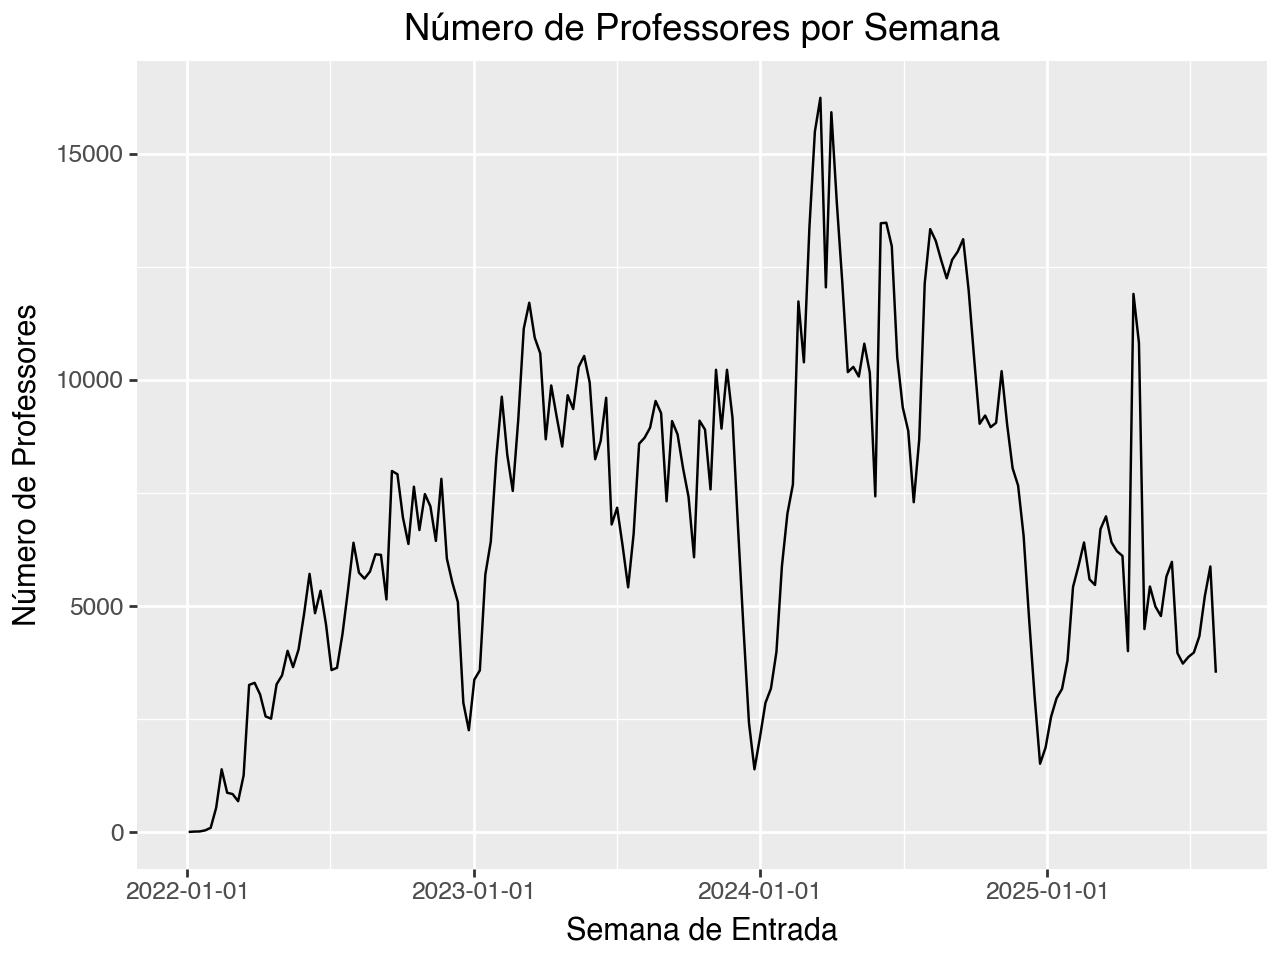

In [21]:
semanal['semana_entrada'] = pd.to_datetime(semanal['semana_entrada'])

(
    p9.ggplot(semanal, p9.aes(x='semana_entrada', y='unique_id')) +
    p9.geom_line() +
    p9.labs(title='Número de Professores por Semana', x='Semana de Entrada', y='Número de Professores')
)

In [22]:
teachers.to_parquet('../data/teachers_entries.parquet')

In [27]:
entries = df.merge(teachers, on='unique_id', how='inner')

In [28]:
entries.head()

,unique_id,user_type,data_inicio,data_fim,duracao_minutos,profid,utm_origin,tela_origem,estado,total_alunos,...,data_entrada,Recency,Frequency,Duration,R_score,F_score,M_score,RFM_Segment,RFM_Score,semana_entrada
0,648c29c1-5c68-4308-bc40-f85a4ab760f8,seo,2022-12-12 15:35:03.601,2022-12-12 15:35:36.305,0.545067,None,SEO Orgânico,Aula SEO,None,NaN,...,2022-12-12 15:35:03.601,969,1,0.545067,1,2,4,124,7,2022-12-12
1,463135f9-2345-4b25-845f-bc52f6e41362,seo,2023-04-11 08:55:55.225,2023-04-11 08:56:56.637,1.023533,None,SEO Ads,Aula SEO,None,NaN,...,2023-04-11 08:55:55.225,849,2,1.045717,2,4,5,245,11,2023-04-10
2,0bb96cab-5bd6-4e80-beff-9bb58590b0cb,seo,2023-03-30 12:27:39.857,2023-03-30 12:27:40.077,0.003667,None,SEO Ads,Aula SEO,None,NaN,...,2023-03-30 12:27:39.857,861,1,0.003667,2,1,2,212,5,2023-03-27
3,6d38f15b-a76d-4b92-bddb-1d6e4ec4deec,seo,2023-06-06 22:20:14.298,2023-06-06 22:20:14.629,0.005517,None,SEO Orgânico,Aula SEO,None,NaN,...,2023-06-06 22:20:14.298,792,2,0.164667,2,5,3,253,10,2023-06-05
4,4c3edd9b-2f40-491f-9e88-5e8bf90accbb,seo,2023-05-29 19:26:15.913,2023-05-29 19:26:16.139,0.003767,None,SEO Orgânico,Aula SEO,None,NaN,...,2023-05-29 19:26:15.913,800,2,1.537567,2,4,5,245,11,2023-05-29


In [25]:
entries.to_parquet('../data/entries.parquet')